In [ ]:
import torch
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as stats
import pylab

In [ ]:
df = pd.read_csv('train.csv')

KstestResult(statistic=np.float64(0.040910076749590796), pvalue=np.float64(0.01466596808743345), statistic_location=np.float64(12.154779351142624), statistic_sign=np.int8(1))
12.024050901109383 0.3994518682611646


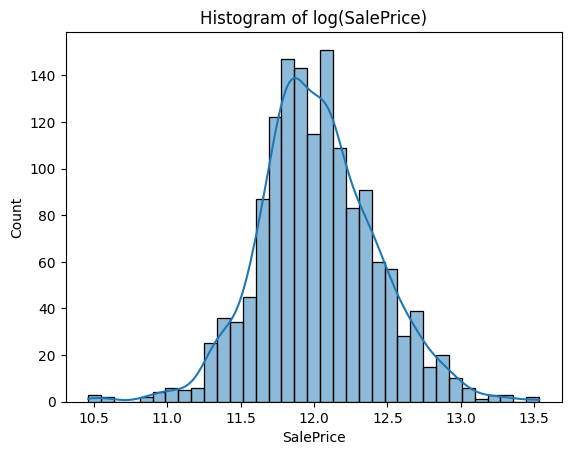

In [ ]:
import seaborn as sns

log_data = np.log(df['SalePrice'])
mu, sigma = log_data.mean(), log_data.std(ddof=1)

print(stats.kstest(log_data, 'norm', args=(mu, sigma)))
print(mu, sigma)

sns.histplot(np.log(df['SalePrice']), kde=True)
plt.title("Histogram of log(SalePrice)")
plt.show()

In [ ]:
from scipy.stats import pearsonr

results = []
alpha = 0.05

for column in df.select_dtypes(np.number).columns:
  corr, p_value = pearsonr(df[column], df['SalePrice'])
  if abs(p_value) < alpha:
    results.append((column, corr))

results.sort(key=lambda x: x[1])
results.reverse()

results

[('SalePrice', np.float64(1.0)),
 ('OverallQual', np.float64(0.7909816005838053)),
 ('GrLivArea', np.float64(0.7086244776126522)),
 ('GarageCars', np.float64(0.6404091972583521)),
 ('GarageArea', np.float64(0.6234314389183617)),
 ('TotalBsmtSF', np.float64(0.6135805515591956)),
 ('1stFlrSF', np.float64(0.6058521846919146)),
 ('FullBath', np.float64(0.5606637627484461)),
 ('TotRmsAbvGrd', np.float64(0.5337231555820283)),
 ('YearBuilt', np.float64(0.522897332879497)),
 ('YearRemodAdd', np.float64(0.5071009671113863)),
 ('Fireplaces', np.float64(0.46692883675152774)),
 ('BsmtFinSF1', np.float64(0.38641980624215333)),
 ('WoodDeckSF', np.float64(0.3244134445681299)),
 ('2ndFlrSF', np.float64(0.3193338028320679)),
 ('OpenPorchSF', np.float64(0.3158562271160553)),
 ('HalfBath', np.float64(0.28410767559478256)),
 ('LotArea', np.float64(0.2638433538714057)),
 ('BsmtFullBath', np.float64(0.2271222331314943)),
 ('BsmtUnfSF', np.float64(0.21447910554696895)),
 ('BedroomAbvGr', np.float64(0.1682131

In [ ]:
import numpy as np
from scipy import stats

alpha = 0.05
results = []

for column in df.select_dtypes(object).columns:
    # Log-transform the target
    df_clean = df[[column, 'SalePrice']].dropna()
    df_clean['LogPrice'] = np.log(df_clean['SalePrice'])

    # Group log-prices by category
    groups = [df_clean[df_clean[column] == cat]['LogPrice'] for cat in df_clean[column].unique()]
    f_statistic, p_value = stats.f_oneway(*groups)

    if p_value < alpha:
        # Calculate eta squared
        grand_mean = df_clean['LogPrice'].mean()
        ss_between = sum(len(group) * (group.mean() - grand_mean) ** 2 for group in groups)
        ss_total = sum((df_clean['LogPrice'] - grand_mean) ** 2)
        eta_squared = ss_between / ss_total

        results.append((column, p_value, eta_squared))

# Sort by smallest p-value
results.sort(key=lambda x: x[2])
results.reverse()

# Display
for col, p, eta in results:
    print(f"{col:20} | p-value: {p:.3e} | eta²: {eta:.3f}")


Neighborhood         | p-value: 4.043e-243 | eta²: 0.571
ExterQual            | p-value: 6.935e-195 | eta²: 0.461
KitchenQual          | p-value: 4.441e-187 | eta²: 0.448
BsmtQual             | p-value: 1.481e-175 | eta²: 0.435
GarageFinish         | p-value: 1.759e-117 | eta²: 0.323
Foundation           | p-value: 1.351e-111 | eta²: 0.304
GarageType           | p-value: 5.885e-91 | eta²: 0.269
HeatingQC            | p-value: 1.615e-82 | eta²: 0.234
Alley                | p-value: 1.277e-06 | eta²: 0.233
BsmtFinType1         | p-value: 1.307e-65 | eta²: 0.198
Exterior1st          | p-value: 1.053e-53 | eta²: 0.182
MSZoning             | p-value: 1.021e-59 | eta²: 0.176
Exterior2nd          | p-value: 2.430e-49 | eta²: 0.171
SaleCondition        | p-value: 1.690e-41 | eta²: 0.129
CentralAir           | p-value: 9.856e-44 | eta²: 0.124
SaleType             | p-value: 5.498e-36 | eta²: 0.120
FireplaceQu          | p-value: 6.410e-20 | eta²: 0.118
BsmtExposure         | p-value: 1.139e-35 

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

# from sklearn.svm import SVR;

# df['totalSF'] = df['1stFlrSF'] + df['2ndFlrSF'] + df['TotalBsmtSF'] + df['OpenPorchSF']

numerical_columns = ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'Fireplaces']
categorical_columns = ["Neighborhood", "ExterQual", "KitchenQual", "BsmtQual", "GarageFinish", "Exterior1st"]
# , "Foundation", "GarageType", "HeatingQC", "Alley", "BsmtFinType1", "Exterior1st", "MSZoning", "Exterior2nd"

# preprocessing pipeline handles missing values and encodes categorical columns using one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_columns),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder())
        ]), categorical_columns)
    ])

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBRegressor())
    # ('classifier', XGBRegressor(learning_rate=0.2998759, n_estimators=112))
])



X = df[numerical_columns + categorical_columns]
y = np.log(df['SalePrice'])

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible



# Fit the model
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', SimpleImputer(),
                                                  ['OverallQual', 'GrLivArea',
                                                   'GarageCars', 'TotalBsmtSF',
                                                   'FullBath', 'YearBuilt',
                                                   'Fireplaces']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder())]),
                                                  ['Neighborhood', 'ExterQual',
                                                   'KitchenQual', 'BsmtQual',
                                                   'GarageFinish...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict on test set
y_pred = model.predict(X_test)

# Reverse log to get predictions in dollars
y_test_actual = np.exp(y_test)
y_pred_actual = np.exp(y_pred)

# Evaluation metrics
r2 = r2_score(y_test_actual, y_pred_actual)
rmse = mean_squared_error(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)

print(f"R² Score: {r2:.4f}")
print(f"RMSE: ${rmse:,.2f}")
print(f"MAE: ${mae:,.2f}")

R² Score: 0.9092
RMSE: $696,246,964.33
MAE: $17,881.42


In [ ]:
test = pd.read_csv('test.csv')

X_pred = test[numerical_columns + categorical_columns]


# Assuming you have predictions in y_pred and corresponding ids (e.g., indices or some unique IDs)
y_pred = np.exp(model.predict(X_pred))

# Create a DataFrame with IDs and predictions
predictions_df = pd.DataFrame({
    'Id': test['Id'],  # Use the appropriate column as the unique identifier (replace 'Id' if different)
    'SalePrice': y_pred
})

# Save to CSV with header
predictions_df.to_csv('predictions.csv', index=False)

print("Predictions saved to predictions.csv")


Predictions saved to predictions.csv
